# Recurrent Neural Networks

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import tqdm
import torch
import torch.nn as nn

### Prepping a time series dataset

Let's look at a kinematics dataset. This dataset shows the joint angle trajectories during flatground walking for 66 different joints of the body.

dict_keys(['ang_jL5S1_Frontal', 'ang_jL5S1_Trans', 'ang_jL5S1_Sagittal', 'ang_jL4L3_Frontal', 'ang_jL4L3_Trans', 'ang_jL4L3_Sagittal', 'ang_jL1T12_Frontal', 'ang_jL1T12_Trans', 'ang_jL1T12_Sagittal', 'ang_jT9T8_Frontal', 'ang_jT9T8_Trans', 'ang_jT9T8_Sagittal', 'ang_jT1C7_Frontal', 'ang_jT1C7_Trans', 'ang_jT1C7_Sagittal', 'ang_jC1Head_Frontal', 'ang_jC1Head_Trans', 'ang_jC1Head_Sagittal', 'ang_jRightT4Shoulder_Frontal', 'ang_jRightT4Shoulder_Trans', 'ang_jRightT4Shoulder_Sagittal', 'ang_jRightShoulder_Frontal', 'ang_jRightShoulder_Trans', 'ang_jRightShoulder_Sagittal', 'ang_jRightElbow_Frontal', 'ang_jRightElbow_Trans', 'ang_jRightElbow_Sagittal', 'ang_jRightWrist_Frontal', 'ang_jRightWrist_Trans', 'ang_jRightWrist_Sagittal', 'ang_jLeftT4Shoulder_Frontal', 'ang_jLeftT4Shoulder_Trans', 'ang_jLeftT4Shoulder_Sagittal', 'ang_jLeftShoulder_Frontal', 'ang_jLeftShoulder_Trans', 'ang_jLeftShoulder_Sagittal', 'ang_jLeftElbow_Frontal', 'ang_jLeftElbow_Trans', 'ang_jLeftElbow_Sagittal', 'ang_jLef

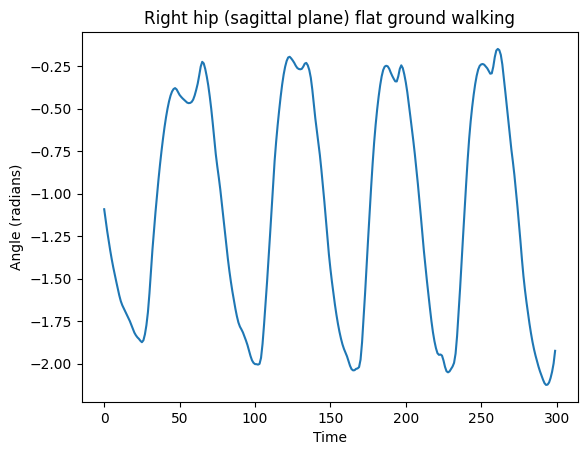

In [2]:
with open('joint_data.pkl', 'rb') as handle:
    joint_data = pickle.load(handle)

# take a look at the different joints recorded
print(joint_data.keys())

# plot out a sample
plt.title('Right hip (sagittal plane) flat ground walking')
plt.xlabel('Time')
plt.ylabel('Angle (radians)')
plt.plot(joint_data['ang_jRightHip_Sagittal'][:300])

It is apparent there is a periodic nature to walking on flat even terrain. How could we build a model that predicts future joint angle movements, eg. for robotic or prosthetic control?

RNNs are well suited to the task, so let's build a network that learns this individual's gait and then can simulate it forward in time.

(6, 18900)


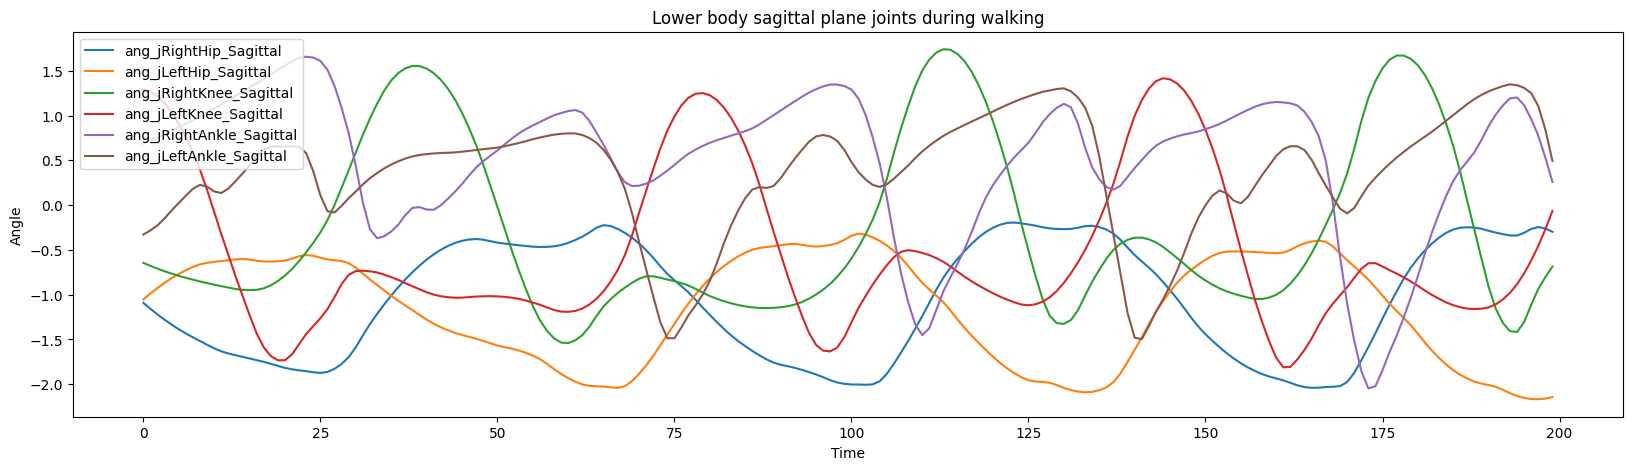

In [3]:
# although the whole body could be used, for efficiency, let's just pick out the lower body sagittal plane joints
joint_feature_names = ['ang_jRightHip_Sagittal','ang_jLeftHip_Sagittal','ang_jRightKnee_Sagittal','ang_jLeftKnee_Sagittal','ang_jRightAnkle_Sagittal','ang_jLeftAnkle_Sagittal']

# grab them out of our data object
joint_trajs = np.stack([joint_data[name] for name in joint_feature_names])
print(joint_trajs.shape)

# plot all joints at once
plt.figure(0, figsize=(20,5))
plt.title('Lower body sagittal plane joints during walking')
plt.xlabel('Time')
plt.ylabel('Angle')
for j in range(len(joint_trajs)):
    plt.plot(joint_trajs[j, :200])
plt.legend(joint_feature_names);

We cannot feed our entire 6x18900 matrix into memory at once. So, we have to chunk our data into windows of time. The **length** of the window is a key hyperparameter for all RNNs, as each model has its own memory limitations.

In [4]:
# let's do a simple split at index 15000.
joint_trajs_train = joint_trajs[:, :15000]
joint_trajs_val = joint_trajs[:, :15000]

# standardize our data according to the train data statistics
means = np.expand_dims(np.mean(joint_trajs_train, axis=1),1)
stds = np.expand_dims(np.std(joint_trajs_train, axis=1),1)
joint_trajs_train = (joint_trajs_train - means) / stds
joint_trajs_val = (joint_trajs_val - means) / stds

# now we can extract a window of our desired length, at a specified stride length 
# we will also set the the target length, or what our model will attempt to predict
window_length = 100
target_length = 25
stride = 10
x_train = np.stack([joint_trajs_train[:,i:i+window_length] for i in np.arange(0, 15000 - window_length - target_length, stride)])
y_train = np.stack([joint_trajs_train[:,i+window_length:i+window_length+target_length] for i in np.arange(0, 15000 - window_length - target_length, stride)])

# what should be the dimension of x_train and y_train be?
# print(x_train.shape)
# print(y_train.shape)

x_val = np.stack([joint_trajs_val[:,i:i+window_length] for i in np.arange(0,3900 - window_length - target_length,stride)])
y_val = np.stack([joint_trajs_val[:,i+window_length:i+window_length+target_length] for i in np.arange(0,3900 - window_length - target_length,stride)])

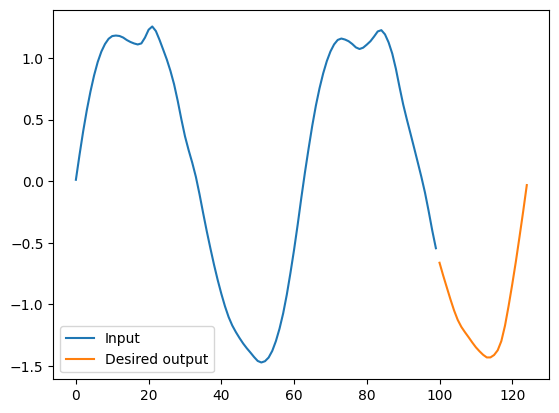

In [5]:
# plot out a training example from our dataset
plt.plot(x_train[500, 0])
plt.plot(range(window_length, window_length + target_length), y_train[500, 0])
plt.legend(['Input','Desired output'])

Our data is ready to go. There are many other ways to featurize time series data that we won't touch on here, as our time series is fairly clean and regular. Other types of times series data, like financial data, often requires high degrees of domain knowledge and additional processing to build useful models.

### Defining the model

An LSTM is a type of recurrent neural network that uses a sophisticated method to "remember" or "forget" data as it passes through the LSTM recurrently. This means it is able to use larger window sizes than traditional RNNs.

In this model, we stack some LSTMs on top of each other, such that at each time step, the hidden states of the whole LSTM stack is updated. Once the entire sequence has passed through the LSTM stack, we use the final hidden states of the LSTM to feed into a set of fully connected layers. Each layer specializes in predicting its own joint trajectory.

What this means is we can learn from *all joints at once* and predict *all joints at once*.

In [6]:
# LSTM model
class StackedLSTM(nn.Module):
    def __init__(self, window_length, hidden_dim, num_layers, num_features, target_length):
        super(StackedLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_features = num_features
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size = window_length, 
                            hidden_size = hidden_dim, 
                            num_layers = num_layers,
                            batch_first=True)
        self.linear_layers = [nn.Linear(hidden_dim, target_length) for _ in range(num_features)]

    def forward(self, x, batch_size):
        # initialize the hidden state and cell state
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)

        # run data through LSTM, update and return new final hidden and cell state
        out, (hidden, cell) = self.lstm(x, (h0, c0))

        # pass the final state through the respective linear layer
        x = torch.stack([self.linear_layers[f](out[:,f]) for f in range(self.num_features)])
        x = torch.swapdims(x, 0, 1)
        return x
    

import math

class CustomDataloader():
    """
    Wraps a dataset and enables fetching of one batch at a time
    """
    def __init__(self, x: torch.Tensor, y: torch.Tensor, batch_size: int = 1, randomize: bool = False):
        self.x = x
        self.y = y
        self.batch_size = batch_size
        self.randomize = randomize
        self.iter = None
        self.num_batches_per_epoch = math.ceil(self.get_length() / self.batch_size)

    def get_length(self):
        return self.x.shape[0]

    def randomize_dataset(self):
        """
        This function randomizes the dataset, while maintaining the relationship between 
        x and y tensors
        """
        indices = torch.randperm(self.x.shape[0])
        self.x = self.x[indices]
        self.y = self.y[indices]

    def generate_iter(self):
        """
        This function converts the dataset into a sequence of batches, and wraps it in
        an iterable that can be called to efficiently fetch one batch at a time
        """
    
        if self.randomize:
            self.randomize_dataset()

        # split dataset into sequence of batches 
        batches = []
        for b_idx in range(self.num_batches_per_epoch):
            batches.append(
                {
                'x_batch':self.x[b_idx * self.batch_size : (b_idx+1) * self.batch_size],
                'y_batch':self.y[b_idx * self.batch_size : (b_idx+1) * self.batch_size],
                'batch_idx':b_idx,
                }
            )
        self.iter = iter(batches)
    
    def fetch_batch(self):
        """
        This function calls next on the batch iterator, and also detects when the final batch
        has been run, so that the iterator can be re-generated for the next epoch
        """
        # if the iter hasn't been generated yet
        if self.iter == None:
            self.generate_iter()

        # fetch the next batch
        batch = next(self.iter)

        # detect if this is the final batch to avoid StopIteration error
        if batch['batch_idx'] == self.num_batches_per_epoch - 1:
            # generate a fresh iter
            self.generate_iter()
        return batch

### Training

Unlike previous models you have trained, LSTMs can require longer training times. On my own home computer, a good model took about 45 minutes. However, after only 5 minutes of training, you can observe decent results already, although the time series may look rather jagged. Training for long periods of time helps smooth the output of the model.

Several parameters worth playing around with that dramatically impact LSTMs
- hidden dimension: 64-256 seems like a good range
- num_layers: 2-4 layers work well. I've found stacking more may actually be detrimental, empirically.
- batch_size: because we have to train a long time, getting batch size to be a reasonably large value like 32-128 may be beneficial to speed it up

*Note: if the data is not standardized precisely, the LSTM can completely fail to learn!*

In [7]:
x_train, x_val = torch.Tensor(x_train), torch.Tensor(x_val)
y_train, y_val = torch.Tensor(y_train), torch.Tensor(y_val)

train_dataloader = CustomDataloader(x = x_train, y = y_train, batch_size=64, randomize=True)
val_dataloader = CustomDataloader(x = x_val, y = y_val, batch_size=64, randomize=False)

model = StackedLSTM(
    window_length=100,
    hidden_dim=256,
    num_layers=3,
    num_features=6,
    target_length=25,
)

# instantiate your optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

# log your losses
train_losses = []
val_losses = []

# define how many epochs to train on
epochs = 1000

# define your loss function for multiclass classification task
# BCE does binary cross entropy automatically for each class
loss_fn = torch.nn.L1Loss(reduction='none')

for _ in tqdm.tqdm(range(epochs)):
    losses = []
    for _ in range(train_dataloader.num_batches_per_epoch):
        # training data forward pass
        optimizer.zero_grad()
        train_batch = train_dataloader.fetch_batch()
        yhat = model(train_batch['x_batch'], len(train_batch['x_batch']))
        train_loss = torch.mean(loss_fn(yhat, train_batch['y_batch']))

        # training data backward pass
        train_loss.backward()
        optimizer.step()
        losses.append(train_loss.detach().numpy())

    # personally, I like to visualize the loss per every iteration, rather than every epoch. I find it more useful to diagnose issues
    train_losses.extend(losses)
    
    losses = []
    for _ in range(val_dataloader.num_batches_per_epoch):
        # validation data forward pass only
        val_batch = val_dataloader.fetch_batch()
        yhat = model(val_batch['x_batch'], len(val_batch['x_batch']))
        val_loss = torch.mean(loss_fn(yhat, val_batch['y_batch']),axis=0)
        losses.append(val_loss.detach().numpy())
    # epoch-level logging for validation though usually makes the most sense
    val_losses.append(np.mean(losses))
    if len(val_losses)%100 == 0:
        print(val_losses[-1])

 10%|█         | 100/1000 [01:02<09:49,  1.53it/s]

0.26641494


 20%|██        | 200/1000 [02:15<09:59,  1.33it/s]

0.18631212


 30%|███       | 300/1000 [03:21<07:06,  1.64it/s]

0.16045052


 40%|████      | 400/1000 [04:23<06:07,  1.63it/s]

0.14769012


 50%|█████     | 500/1000 [37:46<05:47,  1.44it/s]    

0.1397073


 60%|██████    | 600/1000 [38:51<04:14,  1.57it/s]

0.13440248


 70%|███████   | 700/1000 [39:55<03:14,  1.55it/s]

0.13014464


 80%|████████  | 800/1000 [41:00<02:13,  1.50it/s]

0.1267022


 90%|█████████ | 900/1000 [42:06<01:05,  1.54it/s]

0.12375317


100%|██████████| 1000/1000 [43:12<00:00,  2.59s/it]

0.121162884


In [8]:
torch.save(model.state_dict(), 'state_dict.ckpt')

Final validation loss: 0.121162884


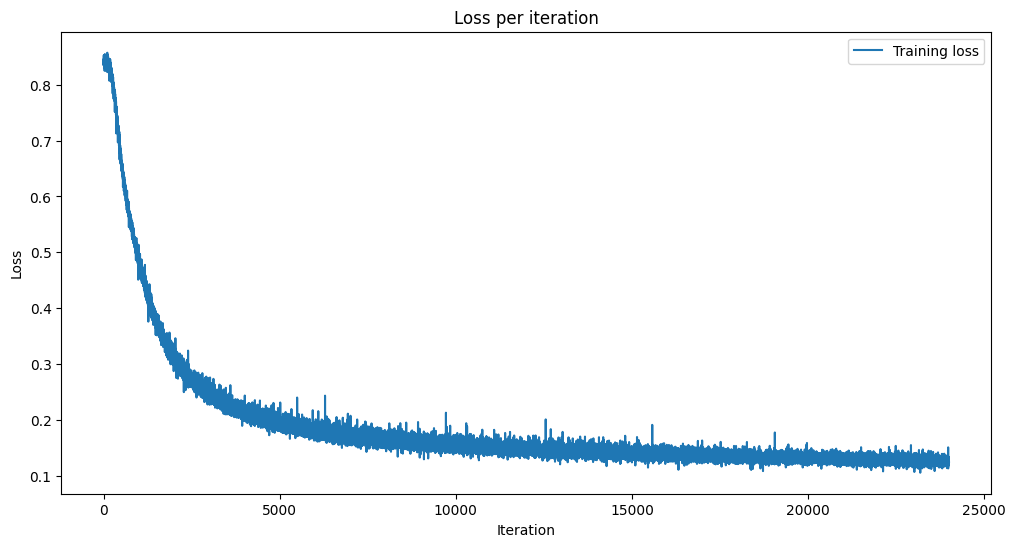

In [9]:
# state_dict = torch.load('state_dict.ckpt')
# model.load_state_dict(state_dict)

plt.figure(0, figsize = (12,6))
plt.title('Loss per iteration')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.plot(train_losses)
#plt.plot(np.linspace(0,len(train_losses),epochs), val_losses)
plt.legend(["Training loss","Validation loss"])
print('Final validation loss:',val_losses[-1])

We can check our performance on our validation set

In [10]:
x_real = []
y_preds = []
y_real = []
for i in range(val_dataloader.num_batches_per_epoch):
    val_batch = val_dataloader.fetch_batch()
    y_preds.append(model(val_batch['x_batch'], len(val_batch['x_batch'])).detach().numpy())
    y_real.append(val_batch["y_batch"].detach().numpy())
    x_real.append(val_batch['x_batch'].detach().numpy())

# now stack all the batches into one array
y_preds = np.vstack(y_preds)
y_real = np.vstack(y_real)
x_real = np.vstack(x_real)

print(y_preds.shape)
print(y_real.shape)
print(x_real.shape)

(378, 6, 25)
(378, 6, 25)
(378, 6, 100)


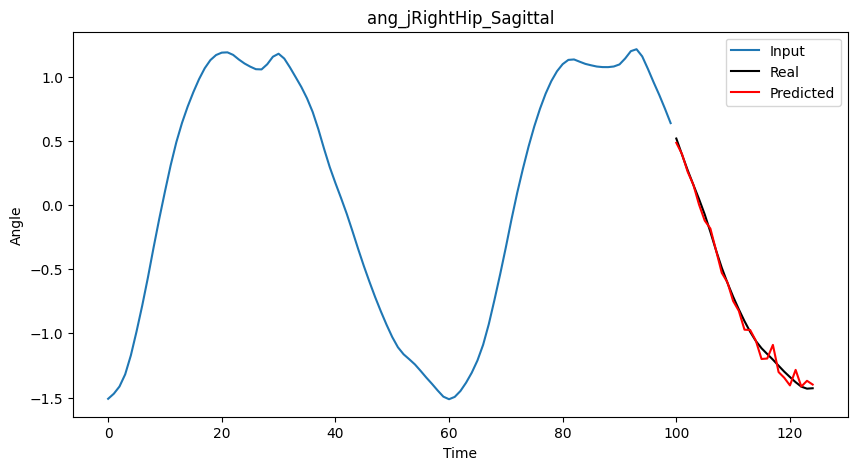

In [11]:
# check how we do on any given sample
sample = np.random.choice(np.arange(0, len(y_preds)))
joint = np.random.choice(np.arange(0,6))
joint = 0
plt.figure(0, figsize = (10,5))
plt.title(f'{joint_feature_names[joint]}')
plt.xlabel('Time')
plt.ylabel('Angle')
plt.plot(x_real[sample, joint])
plt.plot(range(100,125), y_real[sample, joint], color = 'black')
plt.plot(range(100,125), y_preds[sample, joint], color = 'red')
plt.legend(['Input','Real','Predicted'])

### Build a simulator

Now that we have a model, we can wrap up this project by building a gait simulator. By taking the output of the model, and feeding it back in, we can construct a gait simulator.

Try it out yourself.

torch.Size([1, 6, 100])
last_gait torch.Size([1, 6, 100])
torch.Size([1, 6, 25])
last_gait torch.Size([1, 6, 100])
torch.Size([1, 6, 25])
last_gait torch.Size([1, 6, 100])
torch.Size([1, 6, 25])
last_gait torch.Size([1, 6, 100])
torch.Size([1, 6, 25])
last_gait torch.Size([1, 6, 100])
torch.Size([1, 6, 25])


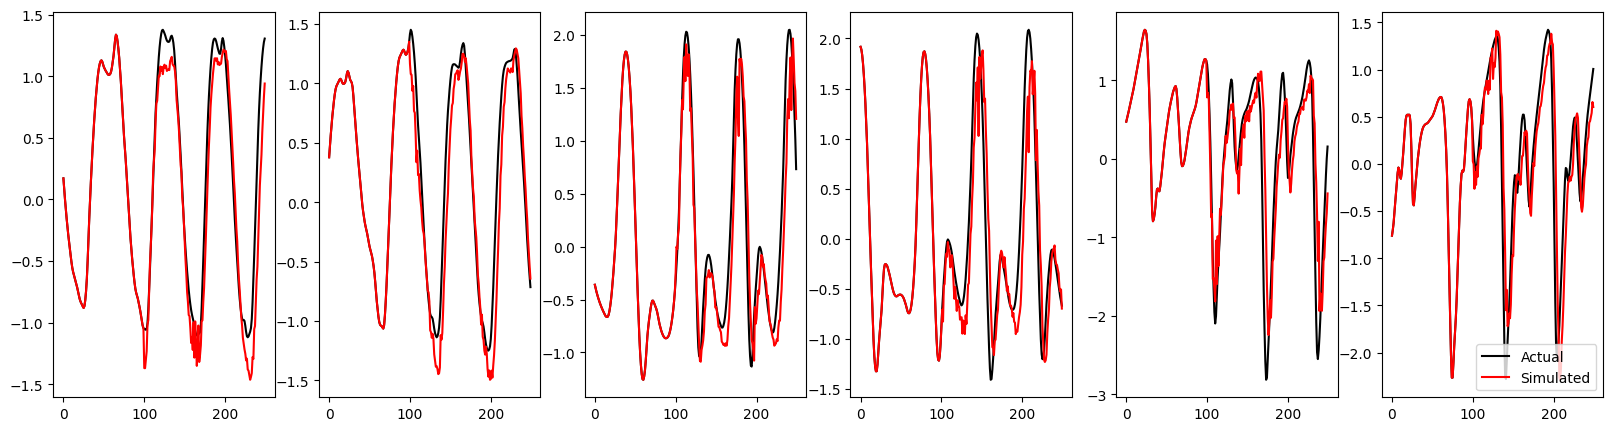

In [12]:
# Here we are taking the first sample, which has 100 timesteps.
# We predict the next 25 time steps for 5 times, using the data from the previous timesteps.
# For example in the first run, we take x from 0 to 100 to predict x from 101 to 125.
# In the second run, we take x from 25 to 125 to predict x from 126 to 150, and so on.

# take the beginning of our data to seed the model
start_gait_sample = x_train[0:1]
print(start_gait_sample.shape)
pred_traj = model(start_gait_sample, 1)
trajectory = torch.cat([start_gait_sample,pred_traj], axis=2)

# run inference for 5 steps
for _ in range(5):
    last_gait = trajectory[:,:,-100:]
    print("last_gait", last_gait.shape)
    pred_traj = model(last_gait, 1)
    print(pred_traj.shape)
    trajectory = torch.cat([trajectory,pred_traj], axis=2)

# plot the results and compare to reality
fig, axs = plt.subplots(1, 6, figsize = (20,5))
for i in range(6):
    axs[i].plot(joint_trajs_train[i,:trajectory.shape[2]], color = 'black')
    axs[i].plot(trajectory[0,i].detach().numpy(), color = 'red')
plt.legend(['Actual','Simulated']);